In [1]:
from common.graph import *
from utils.data_utils import *
import numpy as np

In [2]:
test_graph = Graph('cpu')
test_graph.graph_from_json('../data/IA_raw_data.json')

In [3]:
test_graph.get_border_vertices()

In [7]:
df = load_raw_data('../data/IA_raw_data.json')


In [8]:
is_bordering = np.zeros(len(df))
for i in range(len(df)):
    if test_graph.district_id_on_border_of_vertex.keys().__contains__(i):
        if len(test_graph.district_id_on_border_of_vertex[i]) > 0:
            is_bordering[i] = 1

df['is_bordering'] = is_bordering

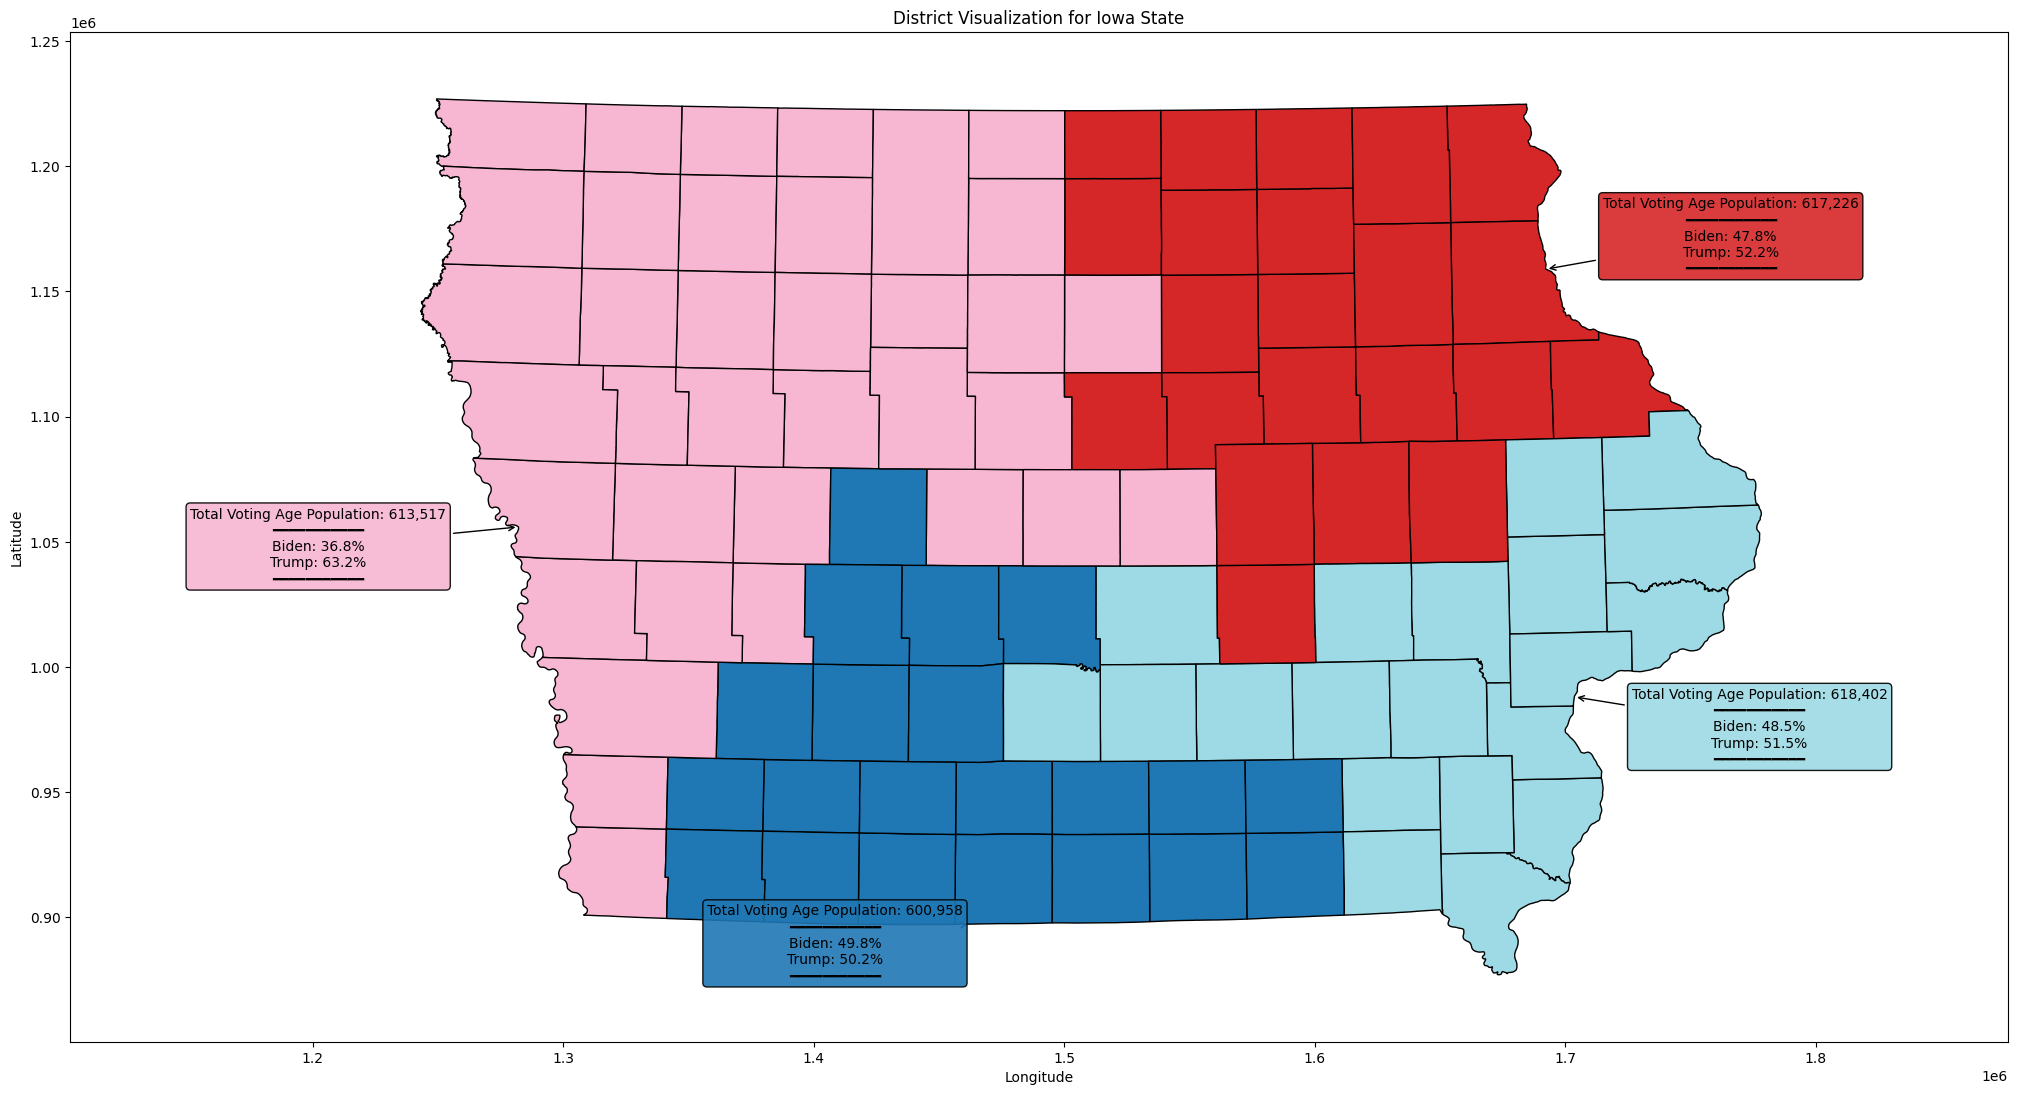

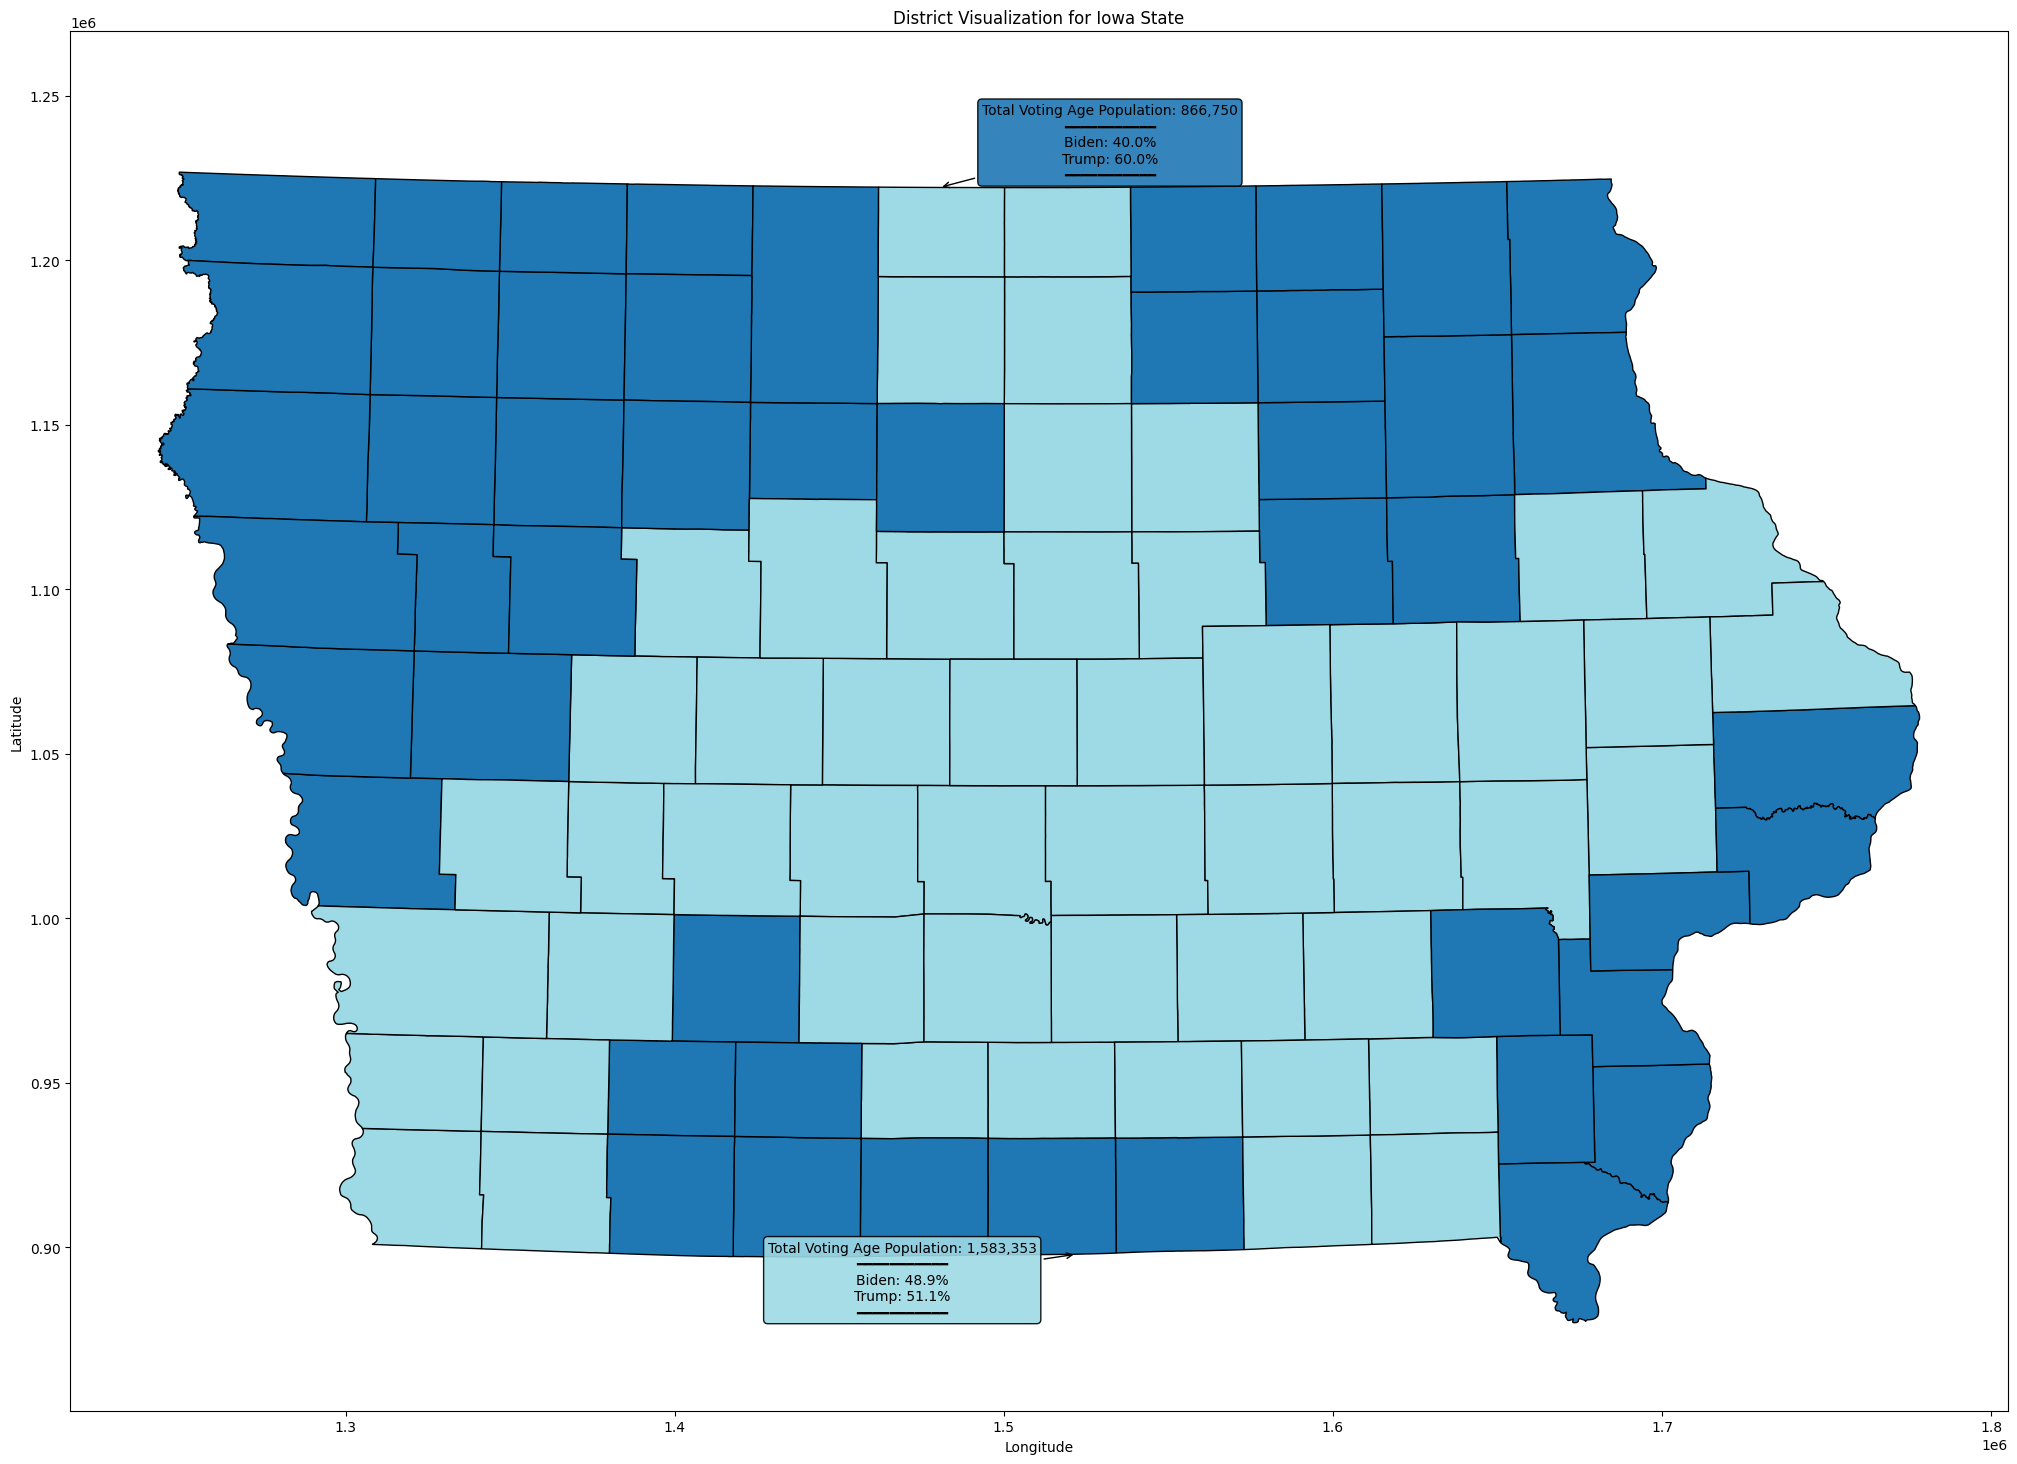

In [9]:
metrics = {
            "total": [("vap", "Voting Age Population")],
            "mean": [],
            "ratio": [[("pre_20_dem_bid", "Biden"), ("pre_20_rep_tru", "Trump")]]
        }
visualize_map_with_geometry(df, district_id_col="cd_2020", state="Iowa", geometry_col="geometry", metrics=metrics)
visualize_map_with_geometry(df, district_id_col="is_bordering", state="Iowa", geometry_col="geometry", metrics=metrics)

In [10]:
to_change  =list(test_graph.vertex_on_border.keys())[1]
print(to_change)
test_graph.change_vertex_district(*to_change)

(5, 1)


In [12]:
district = np.zeros(len(df))
is_bordering = np.zeros(len(df))
for i in range(len(df)):
    if test_graph.district_id_on_border_of_vertex.keys().__contains__(i):
        if len(test_graph.district_id_on_border_of_vertex[i]) > 0:
            is_bordering[i] = 1

df['is_bordering'] = is_bordering
df.loc[to_change[0], 'is_bordering'] = 2
df['cd_2024'] = district

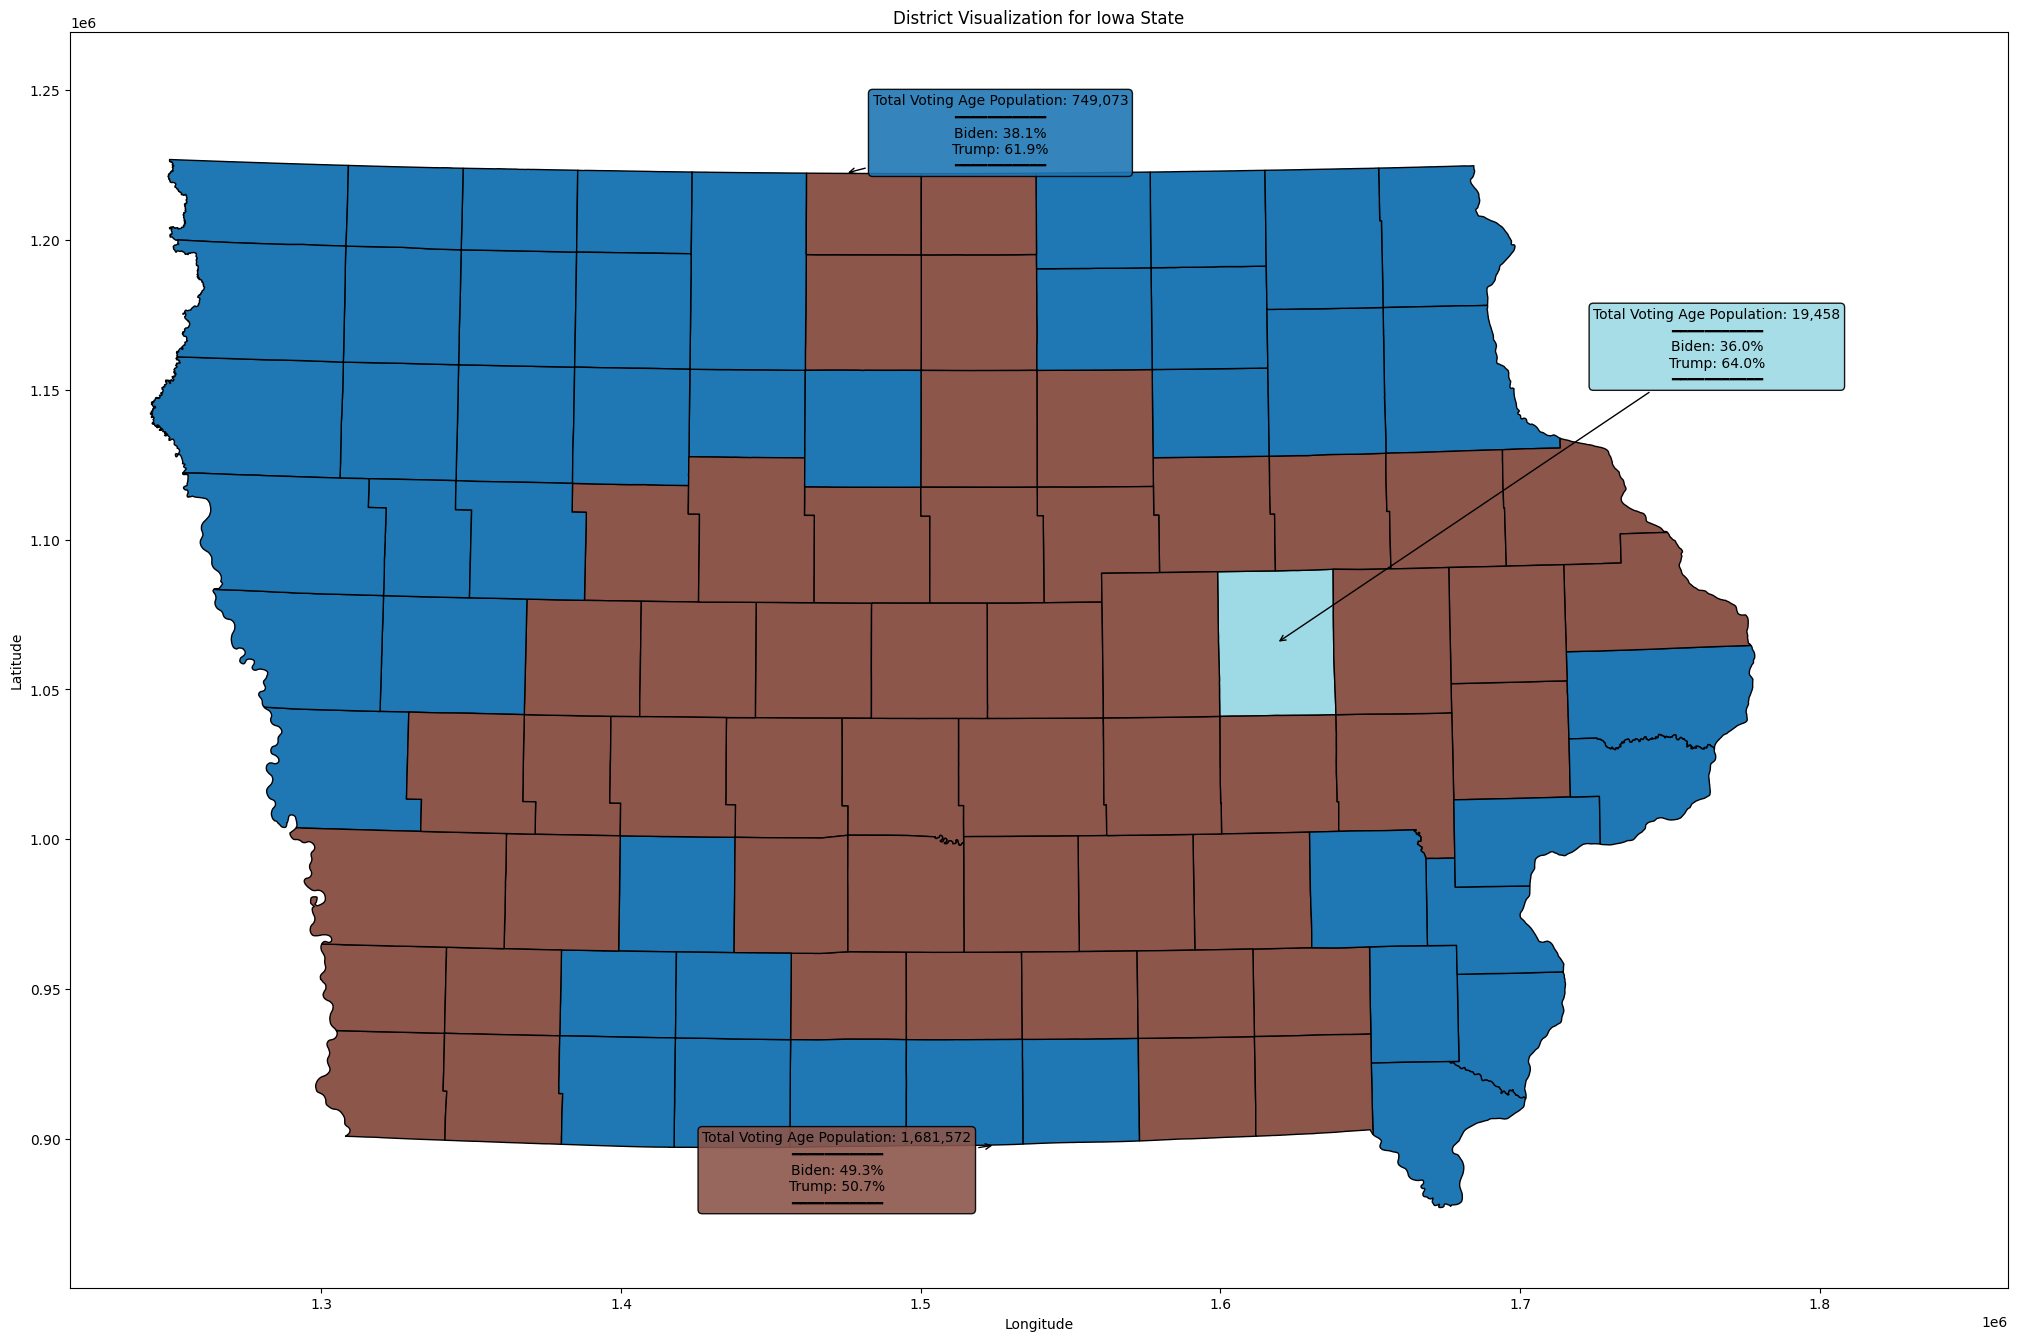

In [13]:
visualize_map_with_geometry(df, district_id_col="is_bordering", state="Iowa", geometry_col="geometry", metrics=metrics)

In [14]:
df['cd_2024'].unique()

array([0.])

In [17]:
import torch
from tqdm import tqdm

from gfn.gflownet import SubTBGFlowNet
from common.env import DistrictEnv
from gfn.modules import DiscretePolicyEstimator, ScalarEstimator
from gfn.samplers import Sampler
from gfn.utils.modules import MLP  # MLP is a simple multi-layer perceptron (MLP)

# 1 - We define the environment.
env = DistrictEnv(json_file="../data/IA_raw_data.json", device_str="cpu")

# 2 - We define the needed modules (neural networks).
# The environment has a preprocessor attribute, which is used to preprocess the state before feeding it to the policy estimator
module_PF = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions
)  # Neural network for the forward policy, with as many outputs as there are actions

module_PB = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions - 1,
    trunk=module_PF.trunk  # We share all the parameters of P_F and P_B, except for the last layer
)
module_logF = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=1,  # Important for ScalarEstimators!
)

# 3 - We define the estimators.
pf_estimator = DiscretePolicyEstimator(module_PF, env.n_actions, is_backward=False, preprocessor=env.preprocessor)
pb_estimator = DiscretePolicyEstimator(module_PB, env.n_actions, is_backward=True, preprocessor=env.preprocessor)
logF_estimator = ScalarEstimator(module=module_logF, preprocessor=env.preprocessor)

# 4 - We define the GFlowNet.
gfn = SubTBGFlowNet(pf=pf_estimator, pb=pb_estimator, logF=logF, lamda=0.9)

# 5 - We define the sampler and the optimizer.
sampler = Sampler(estimator=pf_estimator)  # We use an on-policy sampler, based on the forward policy

# Different policy parameters can have their own LR.
# Log F gets dedicated learning rate (typically higher).
optimizer = torch.optim.Adam(gfn.pf_pb_parameters(), lr=1e-3)
optimizer.add_param_group({"params": gfn.logF_parameters(), "lr": 1e-2})

# 6 - We train the GFlowNet for 1000 iterations, with 16 trajectories per iteration
for i in (pbar := tqdm(range(1000))):
    trajectories = sampler.sample_trajectories(env=env, n=16)
    optimizer.zero_grad()
    loss = gfn.loss(env, trajectories)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})


AttributeError: 'DistrictEnv' object has no attribute 'n_actions'

In [18]:
import torch
from tqdm import tqdm

from gfn.gflownet import TBGFlowNet
from gfn.gym import HyperGrid  # We use the hyper grid environment
from gfn.modules import DiscretePolicyEstimator
from gfn.samplers import Sampler
from gfn.utils.modules import MLP  # is a simple multi-layer perceptron (MLP)

# 1 - We define the environment.
env = HyperGrid(ndim=4, height=8, R0=0.01)  # Grid of size 8x8x8x8

# 2 - We define the needed modules (neural networks).
# The environment has a preprocessor attribute, which is used to preprocess the state before feeding it to the policy estimator
module_PF = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions
)  # Neural network for the forward policy, with as many outputs as there are actions

module_PB = MLP(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions - 1,
    trunk=module_PF.trunk  # We share all the parameters of P_F and P_B, except for the last layer
)

# 3 - We define the estimators.
pf_estimator = DiscretePolicyEstimator(module_PF, env.n_actions, is_backward=False, preprocessor=env.preprocessor)
pb_estimator = DiscretePolicyEstimator(module_PB, env.n_actions, is_backward=True, preprocessor=env.preprocessor)

# 4 - We define the GFlowNet.
gfn = TBGFlowNet(logZ=0., pf=pf_estimator, pb=pb_estimator)  # We initialize logZ to 0

# 5 - We define the sampler and the optimizer.
sampler = Sampler(estimator=pf_estimator)  # We use an on-policy sampler, based on the forward policy

# Different policy parameters can have their own LR.
# Log Z gets dedicated learning rate (typically higher).
optimizer = torch.optim.Adam(gfn.pf_pb_parameters(), lr=1e-3)
optimizer.add_param_group({"params": gfn.logz_parameters(), "lr": 1e-1})

# 6 - We train the GFlowNet for 1000 iterations, with 16 trajectories per iteration
for i in (pbar := tqdm(range(1000))):
    trajectories = sampler.sample_trajectories(env=env, n=16)
    optimizer.zero_grad()
    loss = gfn.loss(env, trajectories)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

100%|██████████| 1000/1000 [00:18<00:00, 53.52it/s, loss=0.106]
